In [1]:
import time
import datetime
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sbs

import itertools
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif

from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
%matplotlib inline

RANDOM_SEED = 42
VERSION = '3D'

In [2]:
data = pd.read_csv('../data/3/tula_yarobl_finished.csv', converters={'okpd': str})
data = data.dropna()
# Балансировка
bad_cntr = data.loc[data.cntr_result == 0]
good_cntr = data.loc[data.cntr_result == 1].sample(bad_cntr.shape[0], random_state=RANDOM_SEED)
data = bad_cntr.append(good_cntr)
print(data.shape)
data.head()

(37546, 39)


,cntrID,ter_good_cntr_share,sup_cntr_num,sup_good_cntr_share,sup_fed_cntr_share,sup_sub_cntr_share,sup_nun_cntr_share,sup_cntr_avg_price,sup_cntr_avg_penalty,sup_no_pnl_share,...,okpd,price,pmp,cntr_lvl,sign_date,exec_date,purch_type,price_higher_pmp,price_too_low,cntr_result
0,1505511,0.958,10,0.80,0.0,0.2,0.8,314948,0.0,1.0,...,0,634088.54,899416.26,3,20150112,20150630,3,0,0,0
1,1505700,0.958,1,0.00,0.0,1.0,0.0,20962,0.0,1.0,...,0,20962.00,22000.00,2,20150112,20150630,4,0,0,0
2,1506010,0.958,5,0.60,0.0,1.0,0.0,112320,0.0,1.0,...,0,102600.00,114000.00,2,20150101,20160331,4,0,0,0
3,1506012,0.958,5,0.60,0.0,1.0,0.0,112320,0.0,1.0,...,0,438000.00,500000.00,2,20150112,20160331,4,0,0,0
4,1506028,0.958,4,0.75,0.0,1.0,0.0,123842,0.0,1.0,...,0,107000.00,158511.70,2,20150112,20151231,3,0,0,0


In [3]:
data.drop(['ter_good_cntr_share', 'cntrID'], inplace=True, axis=1)
data.drop(data[data.exec_date == -1].index, inplace=True)

In [4]:
num_var = [
        'sup_cntr_num', 'sup_cntr_avg_price', 'org_cntr_num', 'org_cntr_avg_price', 
        'price', 'pmp', 'cntr_num_together'
    ]
num_var01 = [
        'sup_good_cntr_share', 'sup_fed_cntr_share', 'sup_sub_cntr_share', 
        'sup_nun_cntr_share', 'sup_cntr_avg_penalty', 'sup_1s_sev', 'sup_1s_org_sev', 'sup_okpd_exp', 
        'sup_no_pnl_share', 'sup_sim_price_share', 'org_good_cntr_share', 'org_fed_cntr_share', 
        'org_sub_cntr_share', 'org_nun_cntr_share', 'org_1s_sev', 'org_1s_sup_sev', 'org_sim_price_share', 
        'okpd_good_cntr_share'
    ]
cat_var = ['sup_status', 'sup_type', 'org_form', 'org_type', 'okpd', 'cntr_lvl', 'purch_type']
cat_bin_var = ['price_higher_pmp', 'price_too_low']


In [5]:
data['okpd_2'] = data['okpd'].apply(lambda a: pd.Series(a[:2]))
data['okpd_3'] = data['okpd'].apply(lambda a: pd.Series(a[:3]))
data['okpd_4'] = data['okpd'].apply(lambda a: pd.Series(a[:4]))

In [6]:
sign_month = data['sign_date'].apply(lambda a: pd.Series(int(str(a)[4:6])))
data['quarter'] = sign_month.apply(lambda a: pd.Series((a - 1) // 3 + 1))

In [7]:
cntr_start = data['sign_date'].apply(lambda a: pd.Series(datetime.datetime.strptime(str(a), "%Y%m%d").date()))
cntr_end = data['exec_date'].apply(lambda a: pd.Series(datetime.datetime.strptime(str(a), "%Y%m%d").date()))
data['cntr_length'] = (cntr_end - cntr_start)[0].apply(lambda a: pd.Series(int(str(a).split()[0])))

In [8]:
datacopy = data.copy()

In [9]:
cat_var.remove('okpd')
cat_var.append('okpd_2')
cat_var.append('okpd_3')
cat_var.append('okpd_4')
cat_var.append('quarter')
num_var.append('cntr_length')

# Анализ данных

## Анализ количественных переменных
### Анализ количественных переменных с нефиксированной областью значений

In [10]:
data[num_var].describe()

,sup_cntr_num,sup_cntr_avg_price,org_cntr_num,org_cntr_avg_price,price,pmp,cntr_num_together,cntr_length
count,37544.000000,3.754400e+04,37544.000000,3.754400e+04,3.754400e+04,3.754400e+04,37544.000000,37544.000000
mean,2392.623082,5.360012e+05,515.253995,6.136351e+05,6.860431e+05,7.441954e+05,24.239319,158.028713
std,3238.826456,8.878901e+06,704.569882,2.114312e+06,8.956323e+06,9.318822e+06,35.117926,106.676383
min,1.000000,0.000000e+00,1.000000,2.673000e+03,1.000000e-02,0.000000e+00,1.000000,0.000000
25%,18.000000,8.772700e+04,116.000000,1.489080e+05,3.910334e+04,4.280376e+04,2.000000,94.000000
50%,251.000000,1.447320e+05,238.000000,2.459070e+05,1.049055e+05,1.182614e+05,9.000000,149.000000
75%,6921.000000,2.344480e+05,653.000000,4.096678e+05,3.385122e+05,3.898000e+05,40.000000,184.000000
max,7651.000000,1.151663e+09,6408.000000,6.803218e+07,1.151663e+09,1.205930e+09,509.000000,2922.000000


In [11]:
# Мода и медиана
result = {'mode': [], 'median': [], 'mean': []}
for nv in num_var:
    result['mode'].append(int(data[nv].mode()[0]))
    result['median'].append(int(data[nv].median()))
    result['mean'].append(int(data[nv].mean()))
result = pd.DataFrame(result, index=num_var)
result = result[['mode', 'median', 'mean']]
result

,mode,median,mean
sup_cntr_num,7651,251,2392
sup_cntr_avg_price,144732,144732,536001
org_cntr_num,260,238,515
org_cntr_avg_price,284701,245907,613635
price,4594368,104905,686043
pmp,0,118261,744195
cntr_num_together,1,9,24
cntr_length,152,149,158


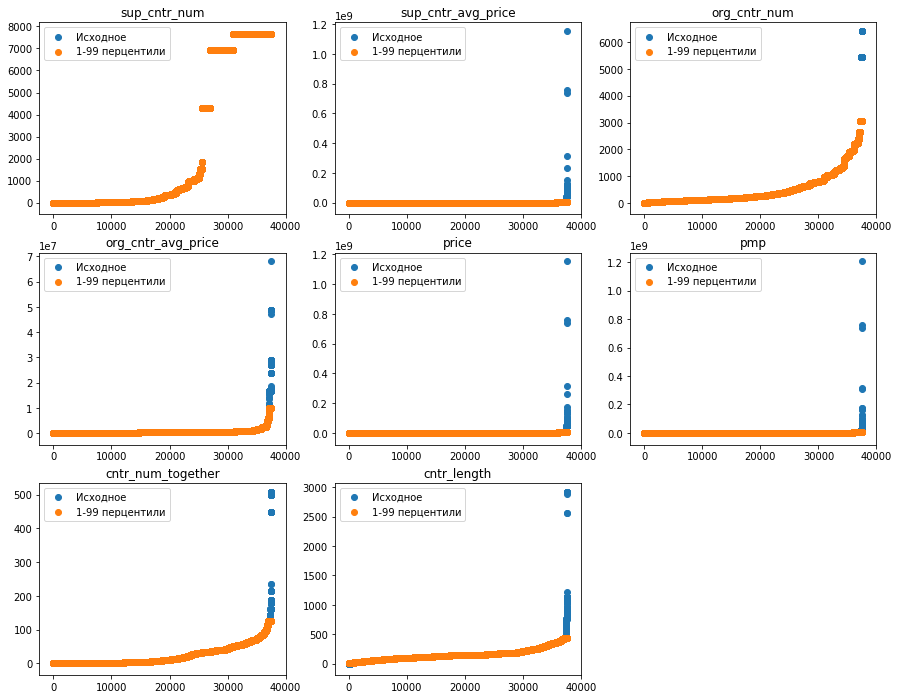

In [12]:
fig = plt.figure(figsize=(15, 12))

for idx, nv in enumerate(num_var):
    ax = fig.add_subplot(330 + idx + 1)
    
    df = data.copy()
    ulimit = np.percentile(df[nv].values, 99)
    dlimit = np.percentile(df[nv].values, 1)
    df.loc[df[nv] > ulimit, nv] = ulimit
    df.loc[df[nv] < dlimit, nv] = dlimit
    
    ax.scatter(range(data.shape[0]), np.sort(data[nv]), label='Исходное')
    ax.scatter(range(df.shape[0]), np.sort(df[nv]), label='1-99 перцентили')
    
    ax.legend()
    ax.set_title(nv)

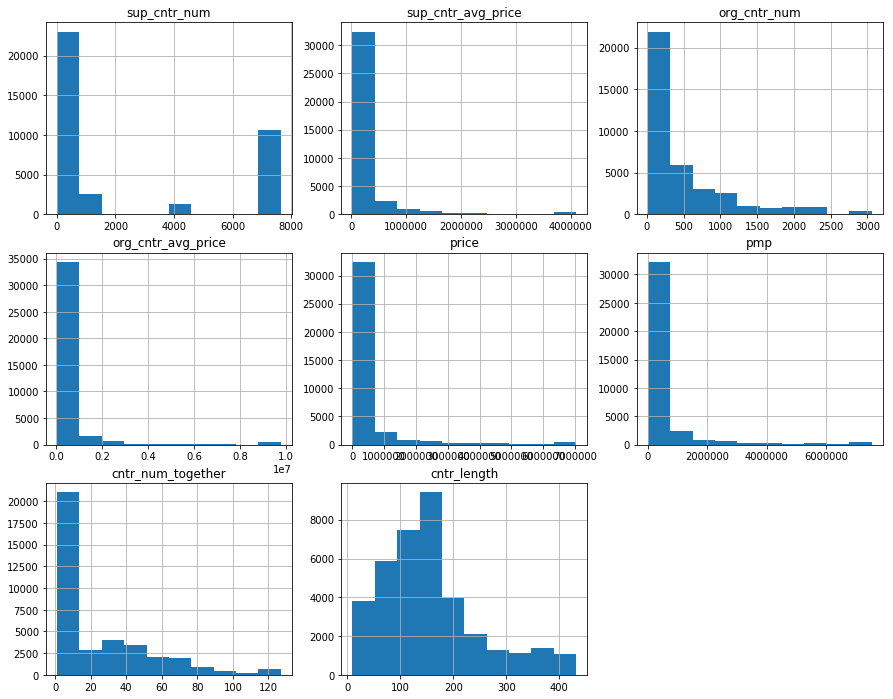

In [13]:
fig = plt.figure(figsize=(15, 12))

for idx, nv in enumerate(num_var):
    ax = fig.add_subplot(330 + idx + 1)
    
    df = data.copy()
    
    ulimit = np.percentile(data[nv].values, 99)
    dlimit = np.percentile(data[nv].values, 1)
    df.loc[df[nv] > ulimit, nv] = ulimit
    df.loc[df[nv] < dlimit, nv] = dlimit
    
    df[nv].hist(ax=ax)
    ax.set_title(nv)

In [14]:
data[num_var + ['cntr_result']].corr()

,sup_cntr_num,sup_cntr_avg_price,org_cntr_num,org_cntr_avg_price,price,pmp,cntr_num_together,cntr_length,cntr_result
sup_cntr_num,1.000000,-0.032985,-0.254238,-0.121680,-0.013031,-0.014185,0.523296,-0.045082,-0.350202
sup_cntr_avg_price,-0.032985,1.000000,0.013607,0.167620,0.962452,0.958254,-0.020996,0.121871,-0.003918
org_cntr_num,-0.254238,0.013607,1.000000,0.060273,0.011625,0.012141,0.023348,0.148073,0.255362
org_cntr_avg_price,-0.121680,0.167620,0.060273,1.000000,0.193840,0.205929,-0.054478,0.073041,0.058637
price,-0.013031,0.962452,0.011625,0.193840,1.000000,0.997599,-0.014515,0.134551,-0.012845
pmp,-0.014185,0.958254,0.012141,0.205929,0.997599,1.000000,-0.016235,0.143028,-0.013181
cntr_num_together,0.523296,-0.020996,0.023348,-0.054478,-0.014515,-0.016235,1.000000,-0.017593,-0.127830
cntr_length,-0.045082,0.121871,0.148073,0.073041,0.134551,0.143028,-0.017593,1.000000,-0.083411
cntr_result,-0.350202,-0.003918,0.255362,0.058637,-0.012845,-0.013181,-0.127830,-0.083411,1.000000


In [16]:
def rate_feature_importance(X_values, y_values, func_list, columns, alias=''):
    """Функция для тестирования важности признаков"""
    
    result_dict = {}
    result_list = []
    
    for func in func_list:
        test = SelectKBest(score_func=func, k='all')
        fit = test.fit(X_values, y_values)
        res = sorted(
            dict(zip(columns, [e for e in list(fit.scores_)])).items(),
            key=lambda a: a[1],
            reverse=True
        )
        
        func_name = str(func).split()[1]
        dict_key = '{}_{}'.format(alias, func_name) if alias else func_name
        
        result_dict[dict_key] = [i[0] for i in res]
        result_list.append(res)
    
    return pd.DataFrame(result_dict), result_list

In [17]:
res_df, res_list = rate_feature_importance(data[num_var].values, data.cntr_result.values, [f_classif], num_var)
res_df['f_score'] = [int(i[1]) for i in res_list[0]]
res_df.columns = ['var_name', 'f_score']
res_df

,var_name,f_score
0,sup_cntr_num,5247
1,org_cntr_num,2618
2,cntr_num_together,623
3,cntr_length,263
4,org_cntr_avg_price,129
5,pmp,6
6,price,6
7,sup_cntr_avg_price,0


### Анализ количественных переменных с фиксированной областью значений [0, 1]

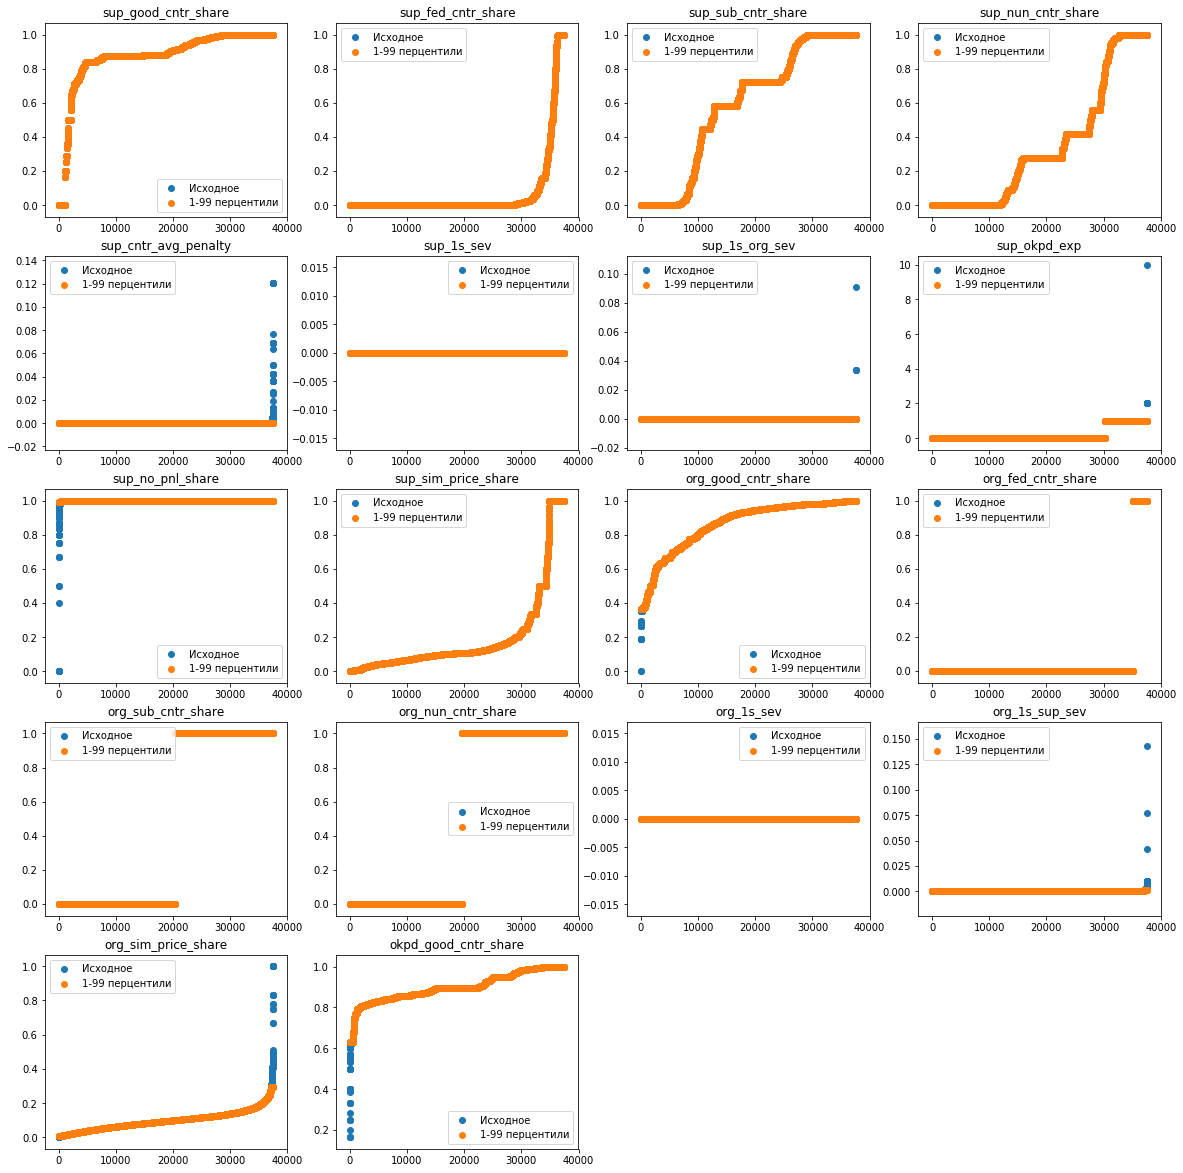

In [18]:
fig = plt.figure(figsize=(20, 25))

for idx, nv in enumerate(num_var01):
    ax = fig.add_subplot(6, 4, idx + 1)
    df = data.copy()
    
    ulimit = np.percentile(data[nv].values, 99)
    dlimit = np.percentile(data[nv].values, 1)
    df.loc[df[nv] > ulimit, nv] = ulimit
    df.loc[df[nv] < dlimit, nv] = dlimit
    
    ax.scatter(range(data.shape[0]), np.sort(data[nv]), label='Исходное')
    ax.scatter(range(df.shape[0]), np.sort(df[nv]), label='1-99 перцентили')
    
    ax.legend()
    ax.set_title(nv)

In [19]:
data[num_var01].describe()

,sup_good_cntr_share,sup_fed_cntr_share,sup_sub_cntr_share,sup_nun_cntr_share,sup_cntr_avg_penalty,sup_1s_sev,sup_1s_org_sev,sup_okpd_exp,sup_no_pnl_share,sup_sim_price_share,org_good_cntr_share,org_fed_cntr_share,org_sub_cntr_share,org_nun_cntr_share,org_1s_sev,org_1s_sup_sev,org_sim_price_share,okpd_good_cntr_share
count,37544.000000,37544.000000,37544.000000,37544.000000,37544.000000,37544.0,37544.000000,37544.000000,37544.000000,37544.000000,37544.000000,37544.000000,37544.000000,37544.000000,37544.0,37544.000000,37544.000000,37544.000000
mean,0.873959,0.069177,0.583237,0.347367,0.000142,0.0,0.000005,0.193400,0.999477,0.196439,0.863390,0.064644,0.456424,0.478878,0.0,0.000036,0.100250,0.899628
std,0.192598,0.215143,0.371353,0.357991,0.002860,0.0,0.000556,0.398393,0.014599,0.255224,0.155322,0.245900,0.498104,0.499560,0.0,0.000930,0.062499,0.073394
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.166667
25%,0.875000,0.000000,0.200000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.063883,0.781750,0.000000,0.000000,0.000000,0.0,0.000000,0.059780,0.855932
50%,0.884000,0.000000,0.721000,0.278000,0.000000,0.0,0.000000,0.000000,1.000000,0.105640,0.935000,0.000000,0.000000,0.000000,0.0,0.000000,0.095040,0.894846
75%,0.991000,0.001000,0.976000,0.556000,0.000000,0.0,0.000000,0.000000,1.000000,0.178632,0.976000,0.000000,1.000000,1.000000,0.0,0.000000,0.128290,0.954686
max,1.000000,1.000000,1.000000,1.000000,0.120910,0.0,0.090910,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.142860,1.000000,1.000000


In [20]:
num_var01_useless = [
    'sup_cntr_avg_penalty', 'sup_1s_sev', 'sup_1s_org_sev', 
    'sup_no_pnl_share', 'org_1s_sev', 'org_1s_sup_sev'
]

In [21]:
# Мода и медиана
result = {'mode': [], 'median': [], 'mean': []}
for nv01 in list(set(num_var01) - set(num_var01_useless)):
    result['mode'].append(data[nv01].mode()[0])
    result['median'].append(data[nv01].median())
    result['mean'].append(data[nv01].mean())
result = pd.DataFrame(result, index=list(set(num_var01) - set(num_var01_useless)))
result = result[['mode', 'median', 'mean']]
result

,mode,median,mean
org_nun_cntr_share,0.000000,0.000000,0.478878
sup_fed_cntr_share,0.000000,0.000000,0.069177
org_good_cntr_share,1.000000,0.935000,0.863390
sup_okpd_exp,0.000000,0.000000,0.193400
sup_sub_cntr_share,1.000000,0.721000,0.583237
org_sim_price_share,0.125000,0.095040,0.100250
sup_nun_cntr_share,0.000000,0.278000,0.347367
org_sub_cntr_share,0.000000,0.000000,0.456424
okpd_good_cntr_share,0.894846,0.894846,0.899628
org_fed_cntr_share,0.000000,0.000000,0.064644


In [22]:
data[list(set(num_var01) - set(num_var01_useless))].describe()

,org_nun_cntr_share,sup_fed_cntr_share,org_good_cntr_share,sup_okpd_exp,sup_sub_cntr_share,org_sim_price_share,sup_nun_cntr_share,org_sub_cntr_share,okpd_good_cntr_share,org_fed_cntr_share,sup_good_cntr_share,sup_sim_price_share
count,37544.000000,37544.000000,37544.000000,37544.000000,37544.000000,37544.000000,37544.000000,37544.000000,37544.000000,37544.000000,37544.000000,37544.000000
mean,0.478878,0.069177,0.863390,0.193400,0.583237,0.100250,0.347367,0.456424,0.899628,0.064644,0.873959,0.196439
std,0.499560,0.215143,0.155322,0.398393,0.371353,0.062499,0.357991,0.498104,0.073394,0.245900,0.192598,0.255224
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.781750,0.000000,0.200000,0.059780,0.000000,0.000000,0.855932,0.000000,0.875000,0.063883
50%,0.000000,0.000000,0.935000,0.000000,0.721000,0.095040,0.278000,0.000000,0.894846,0.000000,0.884000,0.105640
75%,1.000000,0.001000,0.976000,0.000000,0.976000,0.128290,0.556000,1.000000,0.954686,0.000000,0.991000,0.178632
max,1.000000,1.000000,1.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


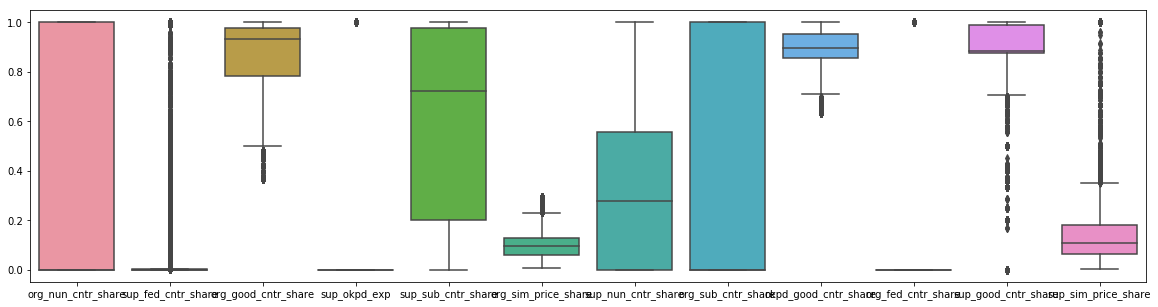

In [23]:
df = data.copy()

for nv01 in list(set(num_var01) - set(num_var01_useless)):
    ulimit = np.percentile(data[nv01].values, 99)
    dlimit = np.percentile(data[nv01].values, 1)
    df.loc[df[nv01] > ulimit, nv01] = ulimit
    df.loc[df[nv01] < dlimit, nv01] = dlimit

ax = plt.figure(figsize=(20, 5)).gca()
sbs.boxplot(data=df[list(set(num_var01) - set(num_var01_useless))], ax=ax)

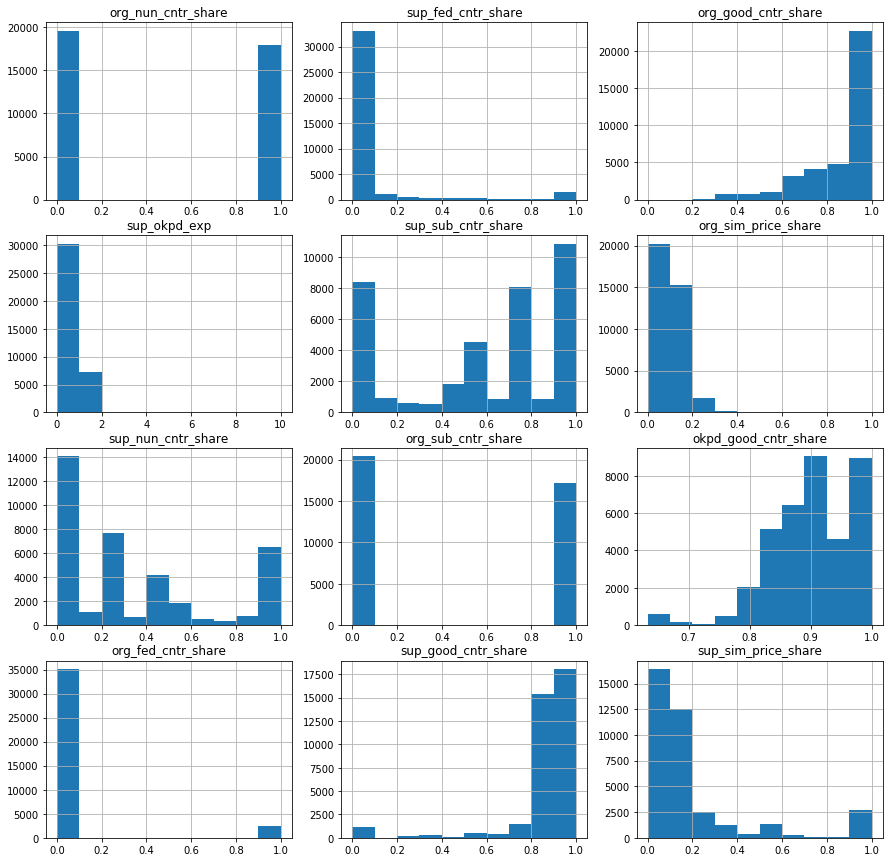

In [24]:
fig = plt.figure(figsize=(15, 15))

for idx, nv01 in enumerate(list(set(num_var01) - set(num_var01_useless))):
    
    ax = fig.add_subplot(4, 3, idx + 1)
    df = data.copy()
    
    ulimit = np.percentile(data[nv].values, 99)
    dlimit = np.percentile(data[nv].values, 1)
    df.loc[df[nv] > ulimit, nv] = ulimit
    df.loc[df[nv] < dlimit, nv] = dlimit
    
    df[nv01].hist(ax=ax)
    ax.set_title(nv01)

In [25]:
data[list(set(num_var01) - set(num_var01_useless)) + ['cntr_result']].corr()

,org_nun_cntr_share,sup_fed_cntr_share,org_good_cntr_share,sup_okpd_exp,sup_sub_cntr_share,org_sim_price_share,sup_nun_cntr_share,org_sub_cntr_share,okpd_good_cntr_share,org_fed_cntr_share,sup_good_cntr_share,sup_sim_price_share,cntr_result
org_nun_cntr_share,1.000000,-0.246107,-0.594357,-0.081390,-0.546391,0.116645,0.715142,-0.878410,-0.424156,-0.252011,-0.138399,-0.187829,-0.435503
sup_fed_cntr_share,-0.246107,1.000000,0.193303,0.142231,-0.351223,-0.015663,-0.236912,-0.175353,0.169398,0.854757,0.013623,0.274864,0.149892
org_good_cntr_share,-0.594357,0.193303,1.000000,0.118452,0.142728,-0.032817,-0.264443,0.511128,0.389951,0.172619,0.075942,0.251545,0.534401
sup_okpd_exp,-0.081390,0.142231,0.118452,1.000000,-0.084925,-0.017606,0.002879,0.017168,0.125950,0.130406,-0.266542,0.567165,0.094712
sup_sub_cntr_share,-0.546391,-0.351223,0.142728,-0.084925,1.000000,-0.226092,-0.826341,0.694578,0.189906,-0.296690,0.170857,-0.094677,0.146978
org_sim_price_share,0.116645,-0.015663,-0.032817,-0.017606,-0.226092,1.000000,0.243790,-0.106732,-0.024128,-0.022736,-0.013675,0.064350,-0.027367
sup_nun_cntr_share,0.715142,-0.236912,-0.264443,0.002879,-0.826341,0.243790,1.000000,-0.615383,-0.299166,-0.206233,-0.185339,-0.066844,-0.242578
org_sub_cntr_share,-0.878410,-0.175353,0.511128,0.017168,0.694578,-0.106732,-0.615383,1.000000,0.353245,-0.240897,0.132085,0.070553,0.367106
okpd_good_cntr_share,-0.424156,0.169398,0.389951,0.125950,0.189906,-0.024128,-0.299166,0.353245,1.000000,0.145861,0.220852,0.233829,0.467908
org_fed_cntr_share,-0.252011,0.854757,0.172619,0.130406,-0.296690,-0.022736,-0.206233,-0.240897,0.145861,1.000000,0.013606,0.238670,0.141126


In [26]:
data[list(set(num_var01) - set(num_var01_useless))].corrwith(data.cntr_result)

org_nun_cntr_share     -0.435503
sup_fed_cntr_share      0.149892
org_good_cntr_share     0.534401
sup_okpd_exp            0.094712
sup_sub_cntr_share      0.146978
org_sim_price_share    -0.027367
sup_nun_cntr_share     -0.242578
org_sub_cntr_share      0.367106
okpd_good_cntr_share    0.467908
org_fed_cntr_share      0.141126
sup_good_cntr_share     0.424108
sup_sim_price_share     0.153690
dtype: float64

In [27]:
res_df, res_list = rate_feature_importance(
    data[list(set(num_var01) - set(num_var01_useless))].values, 
    data.cntr_result.values, [f_classif], num_var01
)
res_df['f_score'] = [int(i[1]) for i in res_list[0]]
res_df.columns = ['var_name', 'f_score']
res_df

,var_name,f_score
0,sup_sub_cntr_share,15007
1,sup_no_pnl_share,10523
2,sup_good_cntr_share,8786
3,org_good_cntr_share,8233
4,sup_okpd_exp,5847
5,sup_1s_org_sev,2347
6,org_fed_cntr_share,908
7,sup_fed_cntr_share,862
8,sup_cntr_avg_penalty,828
9,sup_sim_price_share,762


## Анализ номинальных переменных
### Анализ небинарных переменных

In [28]:
list(zip(cat_var, [len(set(data[cv].values)) for cv in cat_var]))

[('sup_status', 7),
 ('sup_type', 4),
 ('org_form', 71),
 ('org_type', 17),
 ('cntr_lvl', 4),
 ('purch_type', 7),
 ('okpd_2', 75),
 ('okpd_3', 192),
 ('okpd_4', 349),
 ('quarter', 4)]

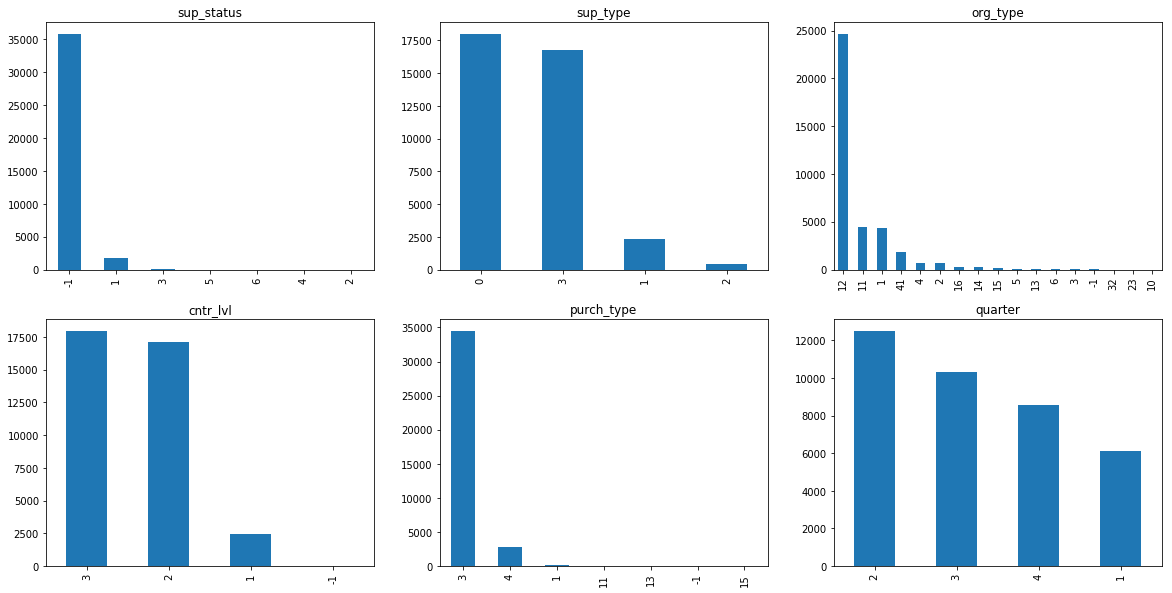

In [29]:
fig = plt.figure(figsize=(20, 10))
idx = 1

for cv in cat_var:
    if cv not in ('okpd_2', 'okpd_3', 'okpd_4', 'org_form'):
        ax = fig.add_subplot(2, 3, idx)
        data[cv].value_counts().plot(kind='bar', ax=ax)
        ax.set_title(cv)
        idx += 1

In [31]:
for cv in cat_var:
    data.loc[data[cv]==-1, cv] = 0

res_df, res_list = rate_feature_importance(data[cat_var].values, data.cntr_result.values, [chi2], cat_var)
res_df['chi2_score'] = [int(i[1]) for i in res_list[0]]
res_df.columns = ['var_name', 'chi2_score']
res_df

,var_name,chi2_score
0,okpd_4,1896693
1,okpd_3,190259
2,okpd_2,20075
3,org_form,1975
4,cntr_lvl,989
5,org_type,718
6,quarter,37
7,sup_status,33
8,sup_type,33
9,purch_type,5


In [32]:
df = data.copy()
for cv in cat_var:
    cnt = data[cv].value_counts()
    for val, count in zip(cnt.index, cnt.values):
        if count / data.shape[0] <= 0.005:
            df.loc[df[cv] == val, cv] = 'NEW'

good_num = df.loc[data.cntr_result == 1].shape[0]
bad_num = df.loc[data.cntr_result == 1].shape[0]
res = {}

for cv in cat_var:
    res[cv] = []
    for val in set(df[cv].values):
        good_with_val = df.loc[(data.cntr_result == 1) & (df[cv] == val)].shape[0]
        bad_with_val = df.loc[(data.cntr_result == 0) & (df[cv] == val)].shape[0]
        p = good_with_val / good_num
        q = bad_with_val / bad_num
        w = np.log(p / q)
        res[cv].append((p - q) * w)

for key, value in res.items():
    print('{}: {:.3f}'.format(key, sum(res[key])))

sup_status: 0.004
sup_type: 0.006
org_form: 0.053
org_type: 0.072
cntr_lvl: 0.820
purch_type: 0.034
okpd_2: 1.207
okpd_3: 1.183
okpd_4: 1.134
quarter: 0.014


### Анализ бинарных переменных

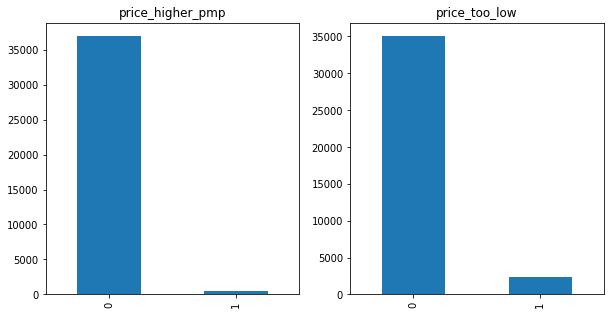

In [33]:
fig = plt.figure(figsize=(10, 5))
for idx, cb in enumerate(cat_bin_var):
    ax = fig.add_subplot(1, 2, idx + 1)
    data[cb].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(cb)

In [34]:
print(data.price_higher_pmp.value_counts().values[1] / data.shape[0])
print(data.price_too_low.value_counts().values[1] / data.shape[0])

0.0142499467292
0.0644577029619


In [35]:
res_df, res_list = rate_feature_importance(data[cat_bin_var].values, data.cntr_result.values, [chi2], cat_bin_var)
res_df['chi2_score'] = [int(i[1]) for i in res_list[0]]
res_df.columns = ['var_name', 'chi2_score']
res_df

,var_name,chi2_score
0,price_too_low,404
1,price_higher_pmp,63


In [36]:
good_num = data.loc[data.cntr_result == 1].shape[0]
bad_num = data.loc[data.cntr_result == 1].shape[0]
res = {}

for cv in cat_bin_var:
    res[cv] = []
    for val in set(data[cv].values):
        good_with_val = data.loc[(data.cntr_result == 1) & (data[cv] == val)].shape[0]
        bad_with_val = data.loc[(data.cntr_result == 0) & (data[cv] == val)].shape[0]
        p = good_with_val / good_num
        q = bad_with_val / bad_num
        w = np.log(p / q)
        res[cv].append((p - q) * w)

for key, value in res.items():
    print('{}: {:.3f}'.format(key, sum(res[key])))

price_higher_pmp: 0.007
price_too_low: 0.049


# Предобработка

## Количественные переменные с нефиксированной облатью значений

In [37]:
num_var.remove('price')
num_var.remove('pmp')
num_var.remove('cntr_num_together')

In [38]:
for nv in data[num_var]:
    ulimit = np.percentile(data[nv].values, 99)
    dlimit = np.percentile(data[nv].values, 1)
    data.loc[data[nv] > ulimit, nv] = ulimit
    data.loc[data[nv] < dlimit, nv] = dlimit
    
for idx, nv in enumerate(('sup_cntr_avg_price', 'org_cntr_avg_price', 'cntr_length')):
    if idx != 2:
        ulimit = np.percentile(data[nv].values, 95)
        data.loc[data[nv] > ulimit, nv] = ulimit  
    else:   
        dlimit = np.percentile(data[nv].values, 5)
        data.loc[data[nv] < dlimit, nv] = dlimit

In [39]:
for nv in data[num_var]:
    data.loc[data[nv] < 1, nv] = 1
    data[nv] = np.log(data[nv])

In [40]:
scaler = StandardScaler()
data[num_var] = scaler.fit_transform(data[num_var])

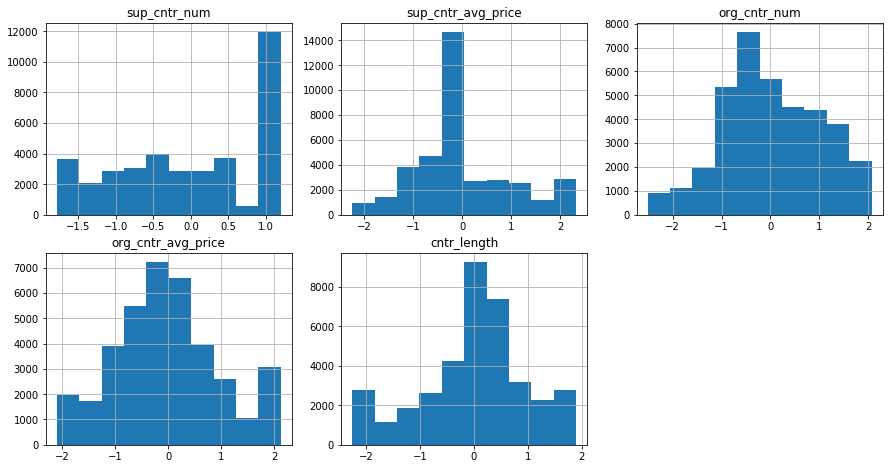

In [41]:
fig = plt.figure(figsize=(15, 12))

for idx, nv in enumerate(num_var):
    ax = fig.add_subplot(330 + idx + 1)
    
    data[nv].hist(ax=ax)
    ax.set_title(nv)

In [42]:
data[num_var + ['cntr_result']].corr()

,sup_cntr_num,sup_cntr_avg_price,org_cntr_num,org_cntr_avg_price,cntr_length,cntr_result
sup_cntr_num,1.000000,-0.218541,-0.229873,-0.326736,0.159318,-0.308596
sup_cntr_avg_price,-0.218541,1.000000,0.319875,0.489085,0.068765,0.135901
org_cntr_num,-0.229873,0.319875,1.000000,0.277529,0.091328,0.310640
org_cntr_avg_price,-0.326736,0.489085,0.277529,1.000000,-0.035068,0.121982
cntr_length,0.159318,0.068765,0.091328,-0.035068,1.000000,-0.180458
cntr_result,-0.308596,0.135901,0.310640,0.121982,-0.180458,1.000000


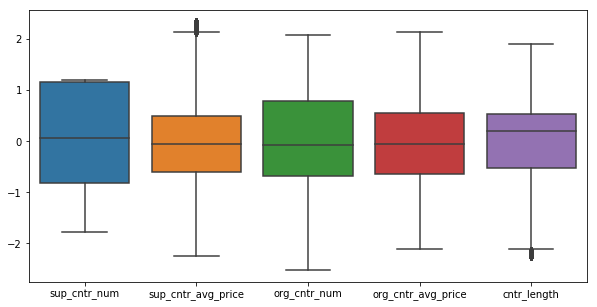

In [43]:
ax = plt.figure(figsize=(10, 5)).gca()
sbs.boxplot(data=data[num_var], ax=ax)

### Предобработка количественных переменных с область определения [0, 1]

In [44]:
useless_num_var01 = [
    'sup_cntr_avg_penalty', 'sup_1s_sev', 'sup_1s_org_sev', 
    'sup_no_pnl_share', 'org_1s_sev', 'org_1s_sup_sev', 'sup_okpd_exp',
    'org_sim_price_share'
]
for var in useless_num_var01:
    num_var01.remove(var)

In [45]:
for nv01 in num_var01:
    ulimit = np.percentile(data[nv01].values, 99)
    dlimit = np.percentile(data[nv01].values, 1)
    data.loc[data[nv01] > ulimit, nv01] = ulimit
    data.loc[data[nv01] < dlimit, nv01] = dlimit

## Предобработка номинальных переменных
### Предобработка номинальных небинарных переменных

In [46]:
cat_var.remove('sup_status')
cat_var.remove('sup_type')

In [47]:
data.loc[data.cntr_lvl == -1, 'cntr_lvl'] = data.cntr_lvl.value_counts().index[0]
data.loc[data.org_type == -1, 'org_type'] = data.org_type.value_counts().index[0]
data.loc[data.org_form == 0, 'org_form'] = data.org_form.value_counts().index[0]
data.loc[data.purch_type == -1, 'purch_type'] = data.purch_type.value_counts().index[0]

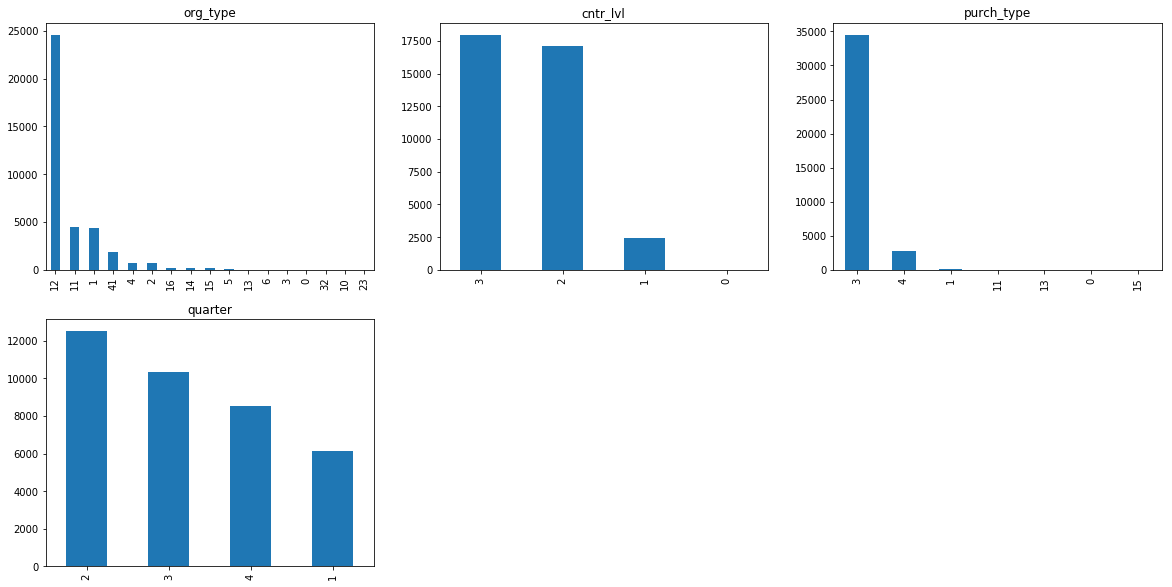

In [48]:
fig = plt.figure(figsize=(20, 10))
idx = 1

for cv in cat_var:
    if cv not in ('okpd_2', 'okpd_3', 'okpd_4', 'org_form'):
        ax = fig.add_subplot(2, 3, idx)
        data[cv].value_counts().plot(kind='bar', ax=ax)
        ax.set_title(cv)
        idx += 1

In [49]:
df = data.copy()
for cv in cat_var:
    cnt = data[cv].value_counts()
    for val, count in zip(cnt.index, cnt.values):
        if count / data.shape[0] <= 0.005:
            data.loc[data[cv] == val, cv] = 'NEW'
    print('{} - было: {}, стало: {} ({:.2f})'.format(
        cv, len(set(df[cv].values)), len(set(data[cv].values)), 
        (len(set(df[cv].values)) - len(set(data[cv].values))) / len(set(df[cv].values))))

org_form - было: 70, стало: 8 (0.89)
org_type - было: 17, стало: 9 (0.47)
cntr_lvl - было: 4, стало: 4 (0.00)
purch_type - было: 7, стало: 3 (0.57)
okpd_2 - было: 75, стало: 21 (0.72)
okpd_3 - было: 192, стало: 30 (0.84)
okpd_4 - было: 349, стало: 38 (0.89)
quarter - было: 4, стало: 4 (0.00)


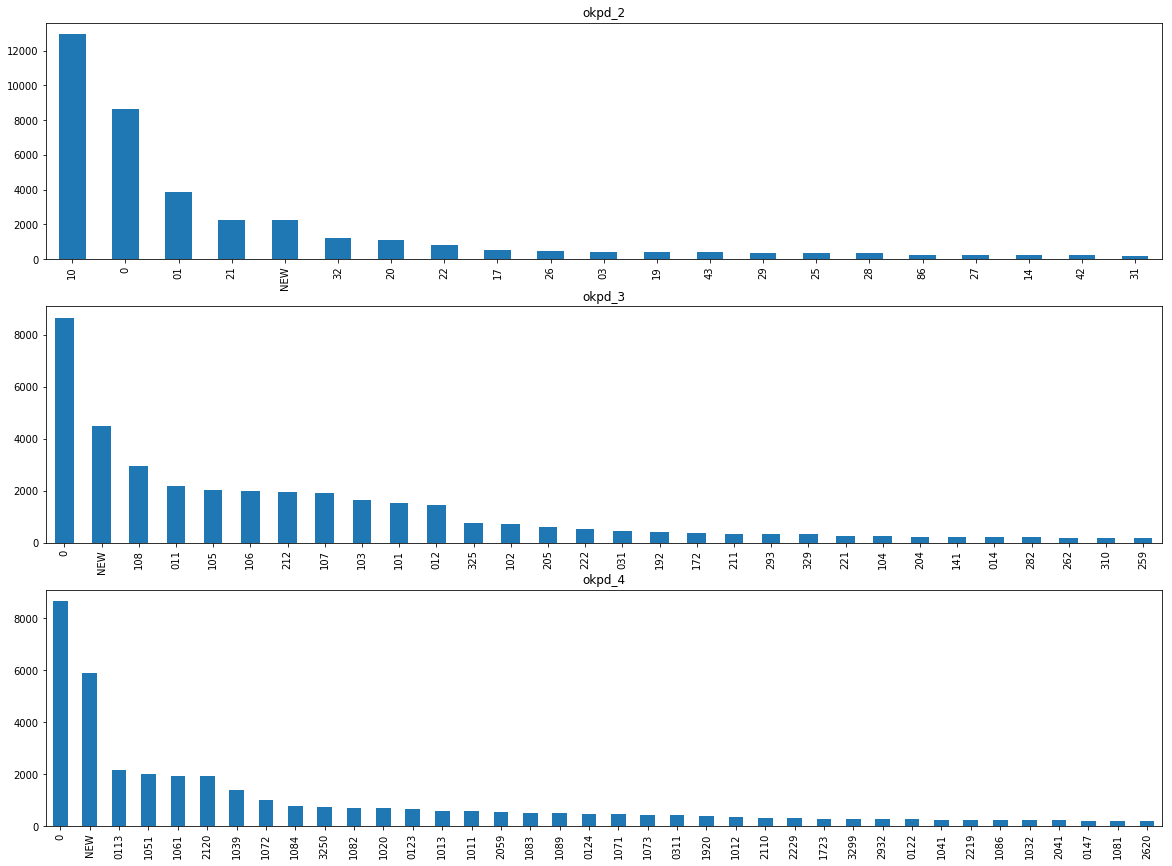

In [50]:
fig = plt.figure(figsize=(20, 20))

for idx, cv in enumerate(('okpd_2', 'okpd_3', 'okpd_4')):
    ax = fig.add_subplot(4, 1, idx + 1)
    data[cv].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(cv)

In [51]:
datacopy_final = data.copy()

In [52]:
df1 = data.copy() # вероятностное кодирование
df2 = data.copy() # частотное кодирование
df3 = data.copy() # WoE кодирование

for cv in cat_var:
    cnt = data[cv].value_counts()
    for val, count in zip(cnt.index, cnt.values):
        df1.loc[df1[cv] == val, cv] = round(count / data.shape[0], 3)
        df2.loc[df2[cv] == val, cv] = count
        
        good_with_val = data.loc[(data.cntr_result == 1) & (data[cv] == val)].shape[0]
        bad_with_val = data.loc[(data.cntr_result == 0) & (data[cv] == val)].shape[0]
        
        p = good_with_val / data.loc[data.cntr_result == 1].shape[0]
        q = bad_with_val / data.loc[data.cntr_result == 0].shape[0]
        df3.loc[df3[cv] == val, cv] = round(np.log(p / q), 3)

### Предобработка бинарных переменных

In [53]:
cat_bin_var.clear()

# Обучение моделей

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.metrics import log_loss, brier_score_loss
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, accuracy_score

from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [55]:
def print_classifier_info(clf_name, y_train_real, y_train_pred, y_test_real, y_test_pred, y_test_pred_proba):
    """Презентация основной информации об обученной модели"""
    
    print_str = (
        '{0}\n{1}\n{2}\nТочность {3:.3f} на обучающей выборке\n'
        'Точность {4:.3f} на тестовой выборке\n'
        'Потеря перекрестной энтропии {5:.3f}\n{1}\n'
    ).format(
        clf_name.upper(),
        "=" * 55 + '\n',
        classification_report(y_test_real, y_test_pred, target_names=('Плохой', 'Хороший')),
        accuracy_score(y_train_real, y_train_pred),
        accuracy_score(y_test_real, y_test_pred),
        log_loss(y_test_real[:len(y_test_pred_proba)], y_test_pred_proba)
    )
    print(print_str)

def real_and_predicted_correlation(y_test_real, y_test_pred, y_test_pred_proba):
    """Корреляция для реальных и предсказываемых значений"""
    data = pd.DataFrame({'result': y_test_real}).join(
        pd.DataFrame({'proba_pred':y_test_pred_proba[:,0]}).join(
            pd.DataFrame({'pred': y_test_pred})
        )
    )
    return data

def plot_confusion_matrix(
    cm, classes, normalize=False, title='Матрица ошибок', cmap=plt.cm.Blues
):
    """Построение матрицы ошибок"""
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Истинное значение')
    plt.xlabel('Предсказываемое значение')
    plt.show()
    
def plot_dependence(res, title=None):
    """
    Построение распределения контрактов по предсказываемой классификатором вероятности
    относения наблюдения к плохому классу
    """
    
    counter0 = Counter() # счетчик плохих контрактов
    counter1 = Counter() # счетчик хороших контрактов

    for index, row in res.iterrows():
        proba = round(row['proba_pred'], 2)

        if not row['result']:
            counter0[proba] += 1
        else:
            counter1[proba] += 1
    
    corr_df0 = pd.DataFrame.from_dict(counter0, orient='index').reset_index().sort_values(['index'])
    corr_df1 = pd.DataFrame.from_dict(counter1, orient='index').reset_index().sort_values(['index'])
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)

    ax.plot(corr_df0['index'], corr_df0[0])
    ax.plot(corr_df1['index'], corr_df1[0])

    plt.legend(['Плохие контракты', 'Хорошие контракты'], loc='upper left')
    plt.xlabel('Предсказываемая вероятность плохого исхода')
    plt.ylabel('Реальное количество контрактов')
    if title:
        plt.title(title)
    plt.show()

def plot_roc_curve(y_test_real, y_test_pred):
    """Построение ROC-кривой"""
    
    fpr, tpr, threshold = roc_curve(y_test_real, y_test_pred)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--', label='Удача')
    plt.legend(loc='lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

def learn_one_model(clf, clf_name, X, y, kfold=10, silent=False):
    """Функция для обучения одной модели"""
    
    if silent:
        print('Обучение %s' % clf_name)
    
    start_time = time.time()
    kfolds_generator = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=RANDOM_SEED)
    for idx, (train_index, test_index) in enumerate(kfolds_generator.split(X, y)):
        if not silent:
            print('Обучение {} разбиения'.format(idx + 1))
        
        X_train = X[train_index]
        X_test = X[test_index]
    
        y_train = y[train_index]
        y_test = y[test_index]
    
        clf.clf.fit(X_train, y_train)
    
        clf.y_train_real = np.concatenate((clf.y_train_real, y_train))
        clf.y_test_real = np.concatenate((clf.y_test_real, y_test))
        clf.y_train_pred = np.concatenate((clf.y_train_pred, clf.clf.predict(X_train)))
        clf.y_test_pred = np.concatenate((clf.y_test_pred, clf.clf.predict(X_test)))
        clf.y_test_pred_proba = np.concatenate((clf.y_test_pred_proba, clf.clf.predict_proba(X_test))) 
    
    clf.res = real_and_predicted_correlation(clf.y_test_real, clf.y_test_pred, clf.y_test_pred_proba)
    clf.train_time = int(time.time() - start_time)
    
    if not silent:
        print("Обучение заняло %s секунд\n" % (time.time() - start_time))
        print_classifier_info(
            clf_name, clf.y_train_real, clf.y_train_pred, 
            clf.y_test_real, clf.y_test_pred, clf.y_test_pred_proba
        )

        print(clf.res.corr())

        plot_confusion_matrix(
            confusion_matrix(clf.y_test_real, clf.y_test_pred), 
            classes=clf.clf.classes_, 
            title='Матрица ошибок'
        )

        plot_dependence(clf.res)
        plot_roc_curve(clf.y_test_real, clf.y_test_pred)

In [56]:
var = []
var.extend(num_var)
var.extend(cat_var)
var.extend(num_var01)
var.extend(cat_bin_var)

In [57]:
sample = df3[var + ['cntr_result']].copy()
X = sample.drop(['cntr_result'], axis=1).values
y = sample.cntr_result.values

In [58]:
sample.shape

(37544, 24)

In [59]:
class Classifier():
    def __init__(self, clf, name, short_name):
        self.clf = clf
        self.name = name
        self.short_name = short_name
    
    y_train_real = np.array([])
    y_test_real = np.array([])
    y_train_pred = np.array([])
    y_test_pred = np.array([])
    y_test_pred_proba = np.zeros((0, 2))

In [60]:
classifiers = [
    Classifier(LogisticRegression(random_state=RANDOM_SEED), 'LogisticRegression', 'LogReg'),
    Classifier(RandomForestClassifier(random_state=RANDOM_SEED), 'RandomForestClassifier', 'RandForest'),
    Classifier(GradientBoostingClassifier(random_state=RANDOM_SEED), 'GradientBoostingClassifier', 'GradBoost'),
    Classifier(XGBClassifier(), 'XGBoostClassifier', 'XGBoost'),
]

In [61]:
scores = []
metrics = ['roc_auc', 'accuracy', 'neg_log_loss']
for clf in classifiers:
    scores.append(
        cross_validate(
            clf.clf, X, y, scoring=metrics, cv=10, return_train_score=True
        )
    )

In [62]:
res = {}
scoring = ['train_{}'.format(metric) for metric in metrics]
scoring.extend(['test_{}'.format(metric) for metric in metrics])

for clf, score in zip(classifiers, scores):
    res[clf.short_name] = [np.mean(score[scor]) for scor in scoring]
    
res = pd.DataFrame(res, index=scoring)
res = res.round(decimals=3)
res = res[['LogReg', 'RandForest', 'GradBoost', 'XGBoost']]
res

,LogReg,RandForest,GradBoost,XGBoost
train_roc_auc,0.928,1.000,0.956,0.953
train_accuracy,0.853,0.994,0.886,0.884
train_neg_log_loss,-0.346,-0.052,-0.262,-0.266
test_roc_auc,0.919,0.854,0.916,0.922
test_accuracy,0.837,0.739,0.821,0.835
test_neg_log_loss,-0.369,-1.804,-0.372,-0.346


In [64]:
for clf in classifiers:
    learn_one_model(clf, clf.short_name, X, y, silent=True)

Обучение LogReg
Обучение RandForest
Обучение GradBoost
Обучение XGBoost


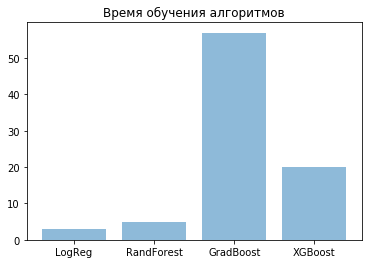

In [65]:
clf_train_time = [clf.train_time for clf in classifiers]
clf_names = [clf.short_name for clf in classifiers]
y_pos = range(len(clf_names))

plt.bar(y_pos, clf_train_time, alpha=0.5)
plt.xticks(y_pos, clf_names)
plt.title('Время обучения алгоритмов')
plt.show()

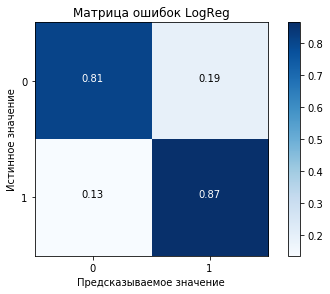

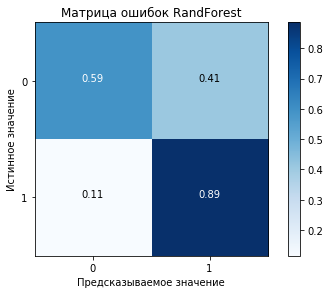

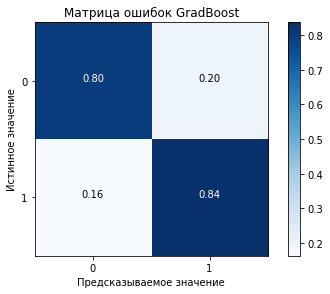

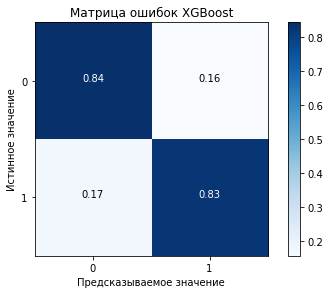

In [66]:
for clf in classifiers:
    plot_confusion_matrix(
        confusion_matrix(y, cross_val_predict(clf.clf, X, y, cv=10)),
        clf.clf.classes_,
        title='Матрица ошибок %s' % clf.short_name,
        normalize=True
    )

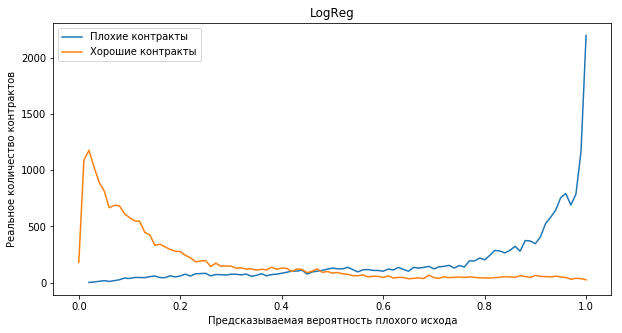

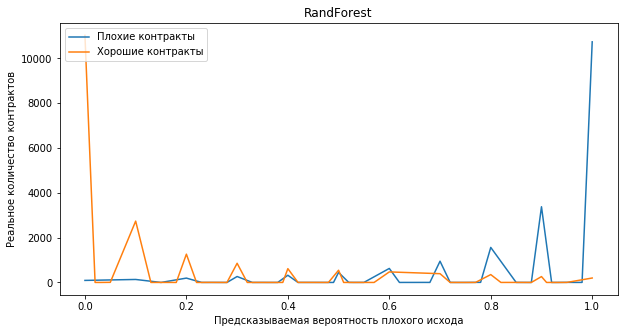

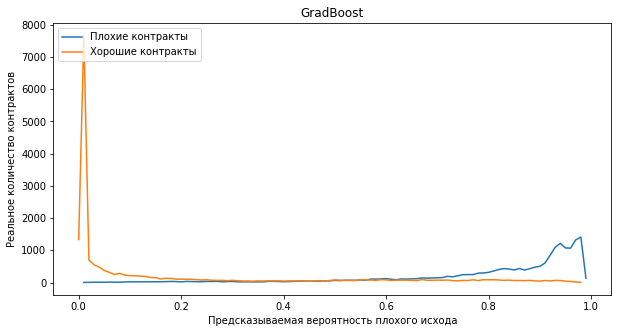

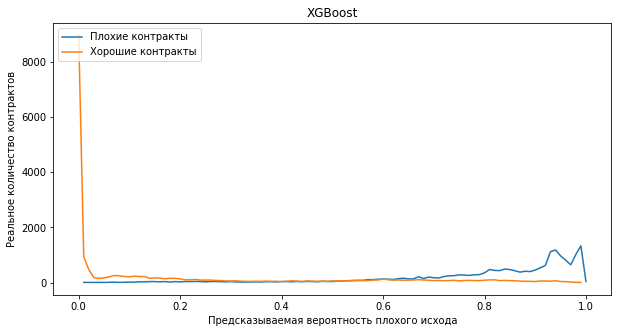

In [67]:
for clf in classifiers:
    plot_dependence(clf.res, title=clf.short_name)

RFE для LogisticRegression
LogReg (67), 2: sup_good_cntr_share, org_good_cntr_share
RFE для RandomForestClassifier
RandForest (125), 4: sup_good_cntr_share, sup_sim_price_share, org_good_cntr_share, okpd_good_cntr_share
RFE для GradientBoostingClassifier
GradBoost (508), 2: sup_good_cntr_share, org_good_cntr_share
RFE для XGBoostClassifier
XGBoost (286), 2: sup_good_cntr_share, org_good_cntr_share


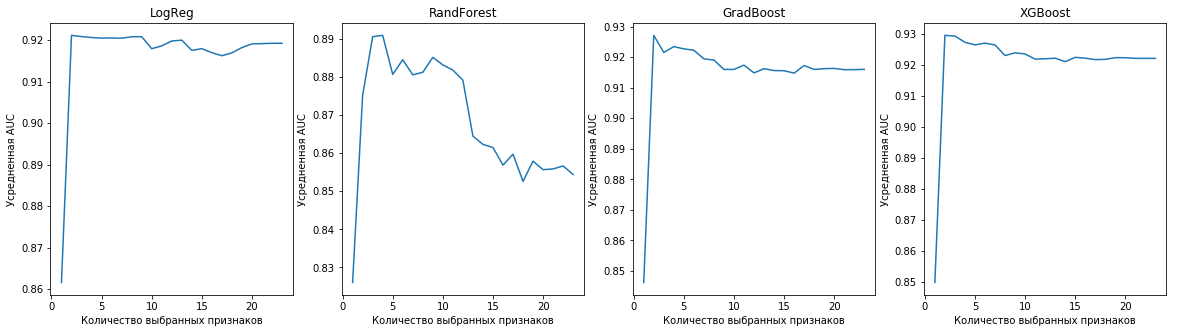

In [68]:
fig = plt.figure(figsize=(20, 5))
rfecvs = []
for idx, clf in enumerate(classifiers):
    print('RFE для %s' % clf.name)
    start_time = time.time()
    ax = fig.add_subplot(1, 4, idx + 1)
    rfecv = RFECV(clf.clf, step=1, cv=StratifiedKFold(10), scoring='roc_auc')
    rfecv.fit(X, y)
    rfecvs.append(rfecv)
    
    ax.set_title(clf.short_name)
    ax.set_xlabel("Количество выбранных признаков")
    ax.set_ylabel("Усредненная AUC")
    ax.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    
    best_set_of_features = [
        column for (score, column) in zip(list(rfecv.support_), list(sample.columns)) if score
    ]

    print("{} ({}), {}: {}".format(
        clf.short_name, 
        int(time.time() - start_time), 
        rfecv.n_features_,
        ', '.join(best_set_of_features)
    ))

In [69]:
for idx, clf in enumerate(classifiers):
    if idx != 1:
        learn_one_model(
            clf, clf.short_name, sample[['sup_good_cntr_share', 'org_good_cntr_share']].values, y, silent=True)
    else:
        learn_one_model(
            clf, clf.short_name, 
            sample[[
                'sup_good_cntr_share', 'org_good_cntr_share', 
                'sup_sim_price_share', 'okpd_good_cntr_share']].values, 
            y, 
            silent=True)

Обучение LogReg
Обучение RandForest
Обучение GradBoost
Обучение XGBoost


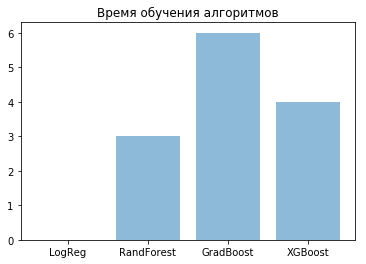

In [75]:
clf_train_time = [clf.train_time for clf in classifiers]
clf_names = [clf.short_name for clf in classifiers]
y_pos = range(len(clf_names))

plt.bar(y_pos, clf_train_time, alpha=0.5)
plt.xticks(y_pos, clf_names)
plt.title('Время обучения алгоритмов')
plt.show()

In [71]:
scores = []
metrics = ['roc_auc', 'accuracy', 'neg_log_loss']
for clf in classifiers:
    if clf.short_name == 'RandForest':
        scores.append(
            cross_validate(
                clf.clf, 
                sample[[
                    'sup_good_cntr_share', 'org_good_cntr_share', 
                    'sup_sim_price_share', 'okpd_good_cntr_share']].values, 
                y, scoring=metrics, cv=10, return_train_score=True
            )
        )
    else:
        scores.append(
        cross_validate(
            clf.clf, 
            sample[['sup_good_cntr_share', 'org_good_cntr_share']].values, 
            y, scoring=metrics, cv=10, return_train_score=True
        )
    )

In [72]:
res = {}
scoring = ['train_{}'.format(metric) for metric in metrics]
scoring.extend(['test_{}'.format(metric) for metric in metrics])

for clf, score in zip(classifiers, scores):
    res[clf.short_name] = [np.mean(score[scor]) for scor in scoring]
    
res = pd.DataFrame(res, index=scoring)
res = res.round(decimals=3)
res = res[['LogReg', 'RandForest', 'GradBoost', 'XGBoost']]
res

,LogReg,RandForest,GradBoost,XGBoost
train_roc_auc,0.921,1.000,0.945,0.943
train_accuracy,0.837,0.990,0.874,0.874
train_neg_log_loss,-0.378,-0.060,-0.287,-0.288
test_roc_auc,0.921,0.893,0.927,0.929
test_accuracy,0.835,0.807,0.846,0.849
test_neg_log_loss,-0.380,-1.439,-0.327,-0.320


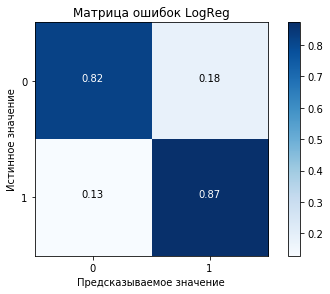

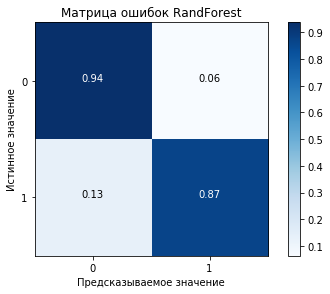

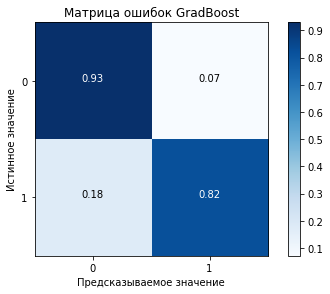

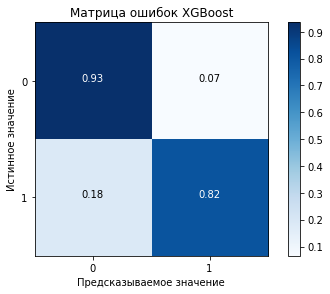

In [73]:
for clf in classifiers:
    plot_confusion_matrix(
        confusion_matrix(clf.y_test_real, clf.y_test_pred),
        clf.clf.classes_,
        title='Матрица ошибок %s' % clf.short_name,
        normalize=True
    )

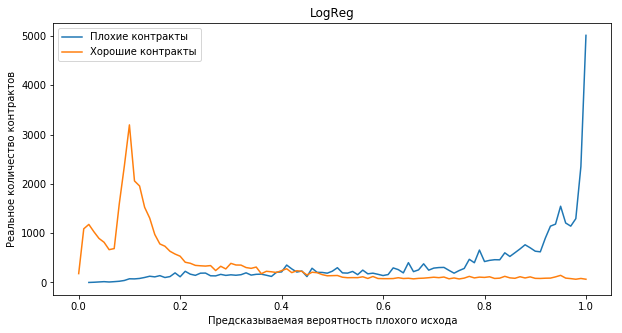

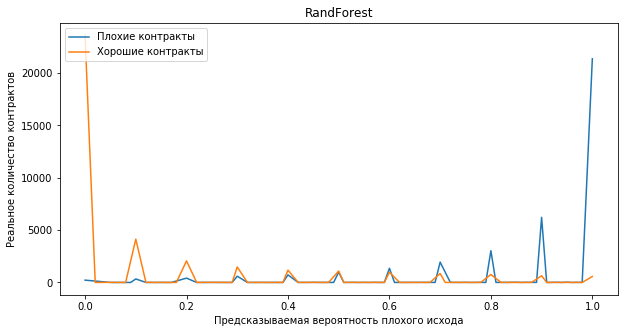

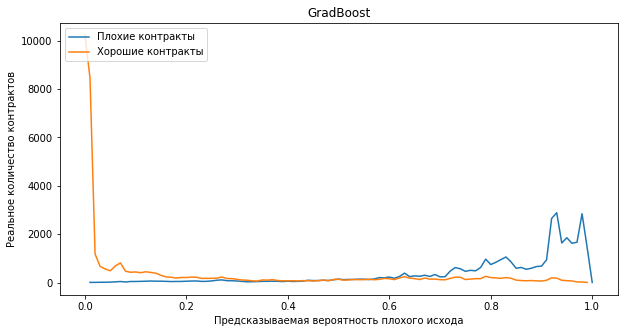

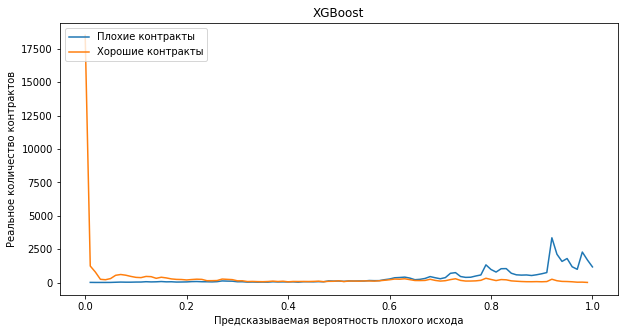

In [74]:
for clf in classifiers:
    plot_dependence(clf.res, title=clf.short_name)